In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import pickle as pkl
import time
from copy import deepcopy

from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn.functional as F
from torchvision.transforms import v2
torch.manual_seed(19)

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

In [2]:
transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPerspective(0.4),
    v2.ToDtype(torch.float32)
])

class NCarsImageDataset(Dataset):
    def __init__(self, img_dir_file, transform=None, target_transform=None):
        self.images = np.load(img_dir_file + '_x.npy')
        self.labels = np.load(img_dir_file + '_y.npy')
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        label_temp = np.zeros((10,))
        label_temp[label] = 1
        if self.stage == 0:
            return self.transform(torch.tensor(image)), torch.tensor(label_temp)
        else:
            return torch.tensor(image), torch.tensor(label_temp)
    
    def set_stage(self, stage):
        self.stage = stage

In [ ]:
from torch.utils.data import DataLoader
data = NCarsImageDataset("./Datasety/CIFAR10-DVS_128", transform=transforms)

generator1 = torch.Generator().manual_seed(42)
test_data, training_data = torch.utils.data.random_split(data, [0.3, 0.7], generator=generator1)

del data

In [4]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, end_maxpool = False):
        super(ResidualBlock, self).__init__()
        if(downsample is not None):
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False),
                            nn.MaxPool2d(kernel_size=2, stride=2)
                            )  # Changed inplace to False
        else:
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.Hardtanh(min_val=0.0, max_val=1.0, inplace=False)
                            )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.Hardtanh(min_val=0.0, max_val=1.0, inplace=False))  # Changed inplace to False
        self.downsample = downsample
        self.relu = nn.Hardtanh(min_val=0.0, max_val=1.0, inplace=False)  # Changed inplace to False
        self.out_channels = out_channels
        self.end_maxpool = end_maxpool

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        if self.end_maxpool:
            out = F.relu(out, inplace=False)
        else:
            out = F.hardtanh(out, inplace=False, min_val=0.0, max_val=1.0)   # Use non-in-place ReLU
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 2, in_channels = 5):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 64, kernel_size = 7, stride = 1, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=False))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2, end_maxpool = True)
        self.avgpool = nn.MaxPool2d(7, stride=1)
        self.fc = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1, end_maxpool = False):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
                nn.BatchNorm2d(planes),
                nn.ReLU(inplace=False),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            if i == blocks-1 and end_maxpool:
                layers.append(block(self.inplanes, planes, end_maxpool = True))
            else:
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.hardtanh(x, inplace=False, min_val=0.0, max_val=1.0)
        x = self.fc2(x)
        return x
    
    def train_model(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001, save_best = False, save_thr = 0.94):
        best_accuracy = 0.0
        total_step = len(train_loader)
        train_accuracy_h = []
        test_accuracy_h = []
        train_loss_h = []
        test_loss_h = []
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)#LinearLR(optimizer,  start_factor=start_factor, end_factor=end_factor, total_iters=total_iters)
        for epoch in range(num_epochs):
            # self.train()
            correct = 0
            total = 0
            running_loss = 0.0
            train_loader.dataset.dataset.set_stage(0)
            for i, (images, labels) in enumerate(tqdm(train_loader)):
                # Move tensors to the configured device
                images = images.float().to("cuda")
                labels = labels.type(torch.FloatTensor)
                labels = labels.to("cuda")


                optimizer.zero_grad()

                # Forward pass
                outputs = self.forward(images)
                loss = criterion(outputs, labels)
                # Backward and optimize
                loss.backward()
                
                optimizer.step()

                # accuracy
                _, predicted = torch.max(outputs.data, 1)
                correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                total += labels.size(0)
                running_loss += loss.item()
                del images, labels, outputs
            train_accuracy_h.append((float(correct))/total)
            train_loss_h.append(running_loss/len(train_loader))
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
                            .format(epoch+1, num_epochs, i+1, total_step, running_loss/len(train_loader), (float(correct))/total))

            scheduler.step()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Validation
            with torch.no_grad():
                correct = 0
                total = 0
                val_loss = 0.0
                valid_loader.dataset.dataset.set_stage(1)
                for images, labels in valid_loader:
                    images = images.float().to("cuda")
                    labels = labels.type(torch.FloatTensor)
                    labels = labels.to("cuda")
                    outputs = self.forward(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    del images, labels, outputs
                if(((100 * correct / total) > best_accuracy) and save_best and ((100 * correct / total) > save_thr)):
                    torch.save(self.state_dict(), "best_resnet50_CIFAR10-DVS_ReLU1_ReLUmaxpool__128x128_FC2_128x128_pretrained_aug_corrected.pt")
                test_accuracy_h.append((float(correct))/total)
                test_loss_h.append(val_loss/len(valid_loader))
                print('Accuracy of the network: {} Loss: {}'.format( correct / total, val_loss/len(valid_loader)))
        return train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h

In [6]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
model_resnet = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes = 10, in_channels=6).to("cuda")
print(model_resnet)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=0.0, max_val=1.0)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=0.0, max_val=1.0)
      )
      (relu): Hardtanh(min_val=0.0, max_val=1.0)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_s

In [7]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)

Using cache found in C:\Users\nikos/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
size_layer = [3, 4, 6, 3]
layers = [(model_resnet.layer0, model.layer1), (model_resnet.layer1, model.layer2), (model_resnet.layer2, model.layer3), (model_resnet.layer3, model.layer4)]
for n in range(len(layers)):
    for i in range(size_layer[n]):
        layers[n][0][i].conv1[0] = layers[n][1][i].conv1
        layers[n][0][i].conv1[0].stride = 1
        layers[n][0][i].conv2[0] = layers[n][1][i].conv2
        layers[n][0][i].conv2[0].stride = 1
        
        layers[n][0][i].conv1[1] = layers[n][1][i].bn1
        layers[n][0][i].conv2[1] = layers[n][1][i].bn2

model_resnet.layer1[0].downsample[0] = model.layer2[0].downsample[0]
model_resnet.layer1[0].downsample[0].stride = 1
model_resnet.layer1[0].downsample[1] = model.layer2[0].downsample[1]

model_resnet.layer2[0].downsample[0] = model.layer3[0].downsample[0]
model_resnet.layer2[0].downsample[0].stride = 1
model_resnet.layer2[0].downsample[1] = model.layer3[0].downsample[1]

model_resnet.layer3[0].downsample[0] = model.layer4[0].downsample[0]
model_resnet.layer3[0].downsample[0].stride = 1
model_resnet.layer3[0].downsample[1] = model.layer4[0].downsample[1]

model_resnet.to("cuda")

ResNet(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=0.0, max_val=1.0)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=0.0, max_val=1.0)
      )
      (relu): Hardtanh(min_val=0.0, max_val=1.0)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(

In [9]:
torch.autograd.set_detect_anomaly(True)
train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h = model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=100,save_best=True, save_thr=48)

100%|██████████| 219/219 [00:48<00:00,  4.51it/s]


Epoch [1/100], Step [219/219], Loss: 2.6209, Accuracy: 0.1059
Accuracy of the network: 0.09866666666666667 Loss: 2.469472050666809


100%|██████████| 219/219 [00:48<00:00,  4.51it/s]


Epoch [2/100], Step [219/219], Loss: 2.4120, Accuracy: 0.1029
Accuracy of the network: 0.11466666666666667 Loss: 2.4140664618066014


100%|██████████| 219/219 [00:48<00:00,  4.53it/s]


Epoch [3/100], Step [219/219], Loss: 2.3572, Accuracy: 0.1171
Accuracy of the network: 0.12666666666666668 Loss: 2.2910896641142826


100%|██████████| 219/219 [00:48<00:00,  4.50it/s]


Epoch [4/100], Step [219/219], Loss: 2.2869, Accuracy: 0.1254
Accuracy of the network: 0.16466666666666666 Loss: 2.289617710925163


100%|██████████| 219/219 [00:48<00:00,  4.51it/s]


Epoch [5/100], Step [219/219], Loss: 2.2086, Accuracy: 0.1513
Accuracy of the network: 0.187 Loss: 2.1446301721512


100%|██████████| 219/219 [00:48<00:00,  4.52it/s]


Epoch [6/100], Step [219/219], Loss: 2.1611, Accuracy: 0.1656
Accuracy of the network: 0.16066666666666668 Loss: 2.1249396179584745


100%|██████████| 219/219 [00:48<00:00,  4.51it/s]


Epoch [7/100], Step [219/219], Loss: 2.1294, Accuracy: 0.1807
Accuracy of the network: 0.18933333333333333 Loss: 2.1001960406912135


100%|██████████| 219/219 [00:48<00:00,  4.52it/s]


Epoch [8/100], Step [219/219], Loss: 2.1141, Accuracy: 0.1850
Accuracy of the network: 0.17766666666666667 Loss: 2.1290731518826584


100%|██████████| 219/219 [00:48<00:00,  4.52it/s]


Epoch [9/100], Step [219/219], Loss: 2.0778, Accuracy: 0.2063
Accuracy of the network: 0.226 Loss: 2.0270679428222333


100%|██████████| 219/219 [00:48<00:00,  4.51it/s]


Epoch [10/100], Step [219/219], Loss: 2.0373, Accuracy: 0.2301
Accuracy of the network: 0.24233333333333335 Loss: 2.0097766264956047


100%|██████████| 219/219 [00:48<00:00,  4.49it/s]


Epoch [11/100], Step [219/219], Loss: 2.0143, Accuracy: 0.2356
Accuracy of the network: 0.22433333333333333 Loss: 2.0188408963223723


100%|██████████| 219/219 [00:48<00:00,  4.51it/s]


Epoch [12/100], Step [219/219], Loss: 1.9883, Accuracy: 0.2486
Accuracy of the network: 0.25733333333333336 Loss: 1.9711175002950303


100%|██████████| 219/219 [00:48<00:00,  4.50it/s]


Epoch [13/100], Step [219/219], Loss: 1.9487, Accuracy: 0.2624
Accuracy of the network: 0.22733333333333333 Loss: 2.0189300179481506


100%|██████████| 219/219 [00:48<00:00,  4.51it/s]


Epoch [14/100], Step [219/219], Loss: 1.9296, Accuracy: 0.2726
Accuracy of the network: 0.2763333333333333 Loss: 1.918863370063457


100%|██████████| 219/219 [00:48<00:00,  4.51it/s]


Epoch [15/100], Step [219/219], Loss: 1.9231, Accuracy: 0.2761
Accuracy of the network: 0.259 Loss: 1.906248390674591


100%|██████████| 219/219 [00:48<00:00,  4.50it/s]


Epoch [16/100], Step [219/219], Loss: 1.9104, Accuracy: 0.2720
Accuracy of the network: 0.2783333333333333 Loss: 1.9092194767708475


100%|██████████| 219/219 [00:48<00:00,  4.50it/s]


Epoch [17/100], Step [219/219], Loss: 1.8904, Accuracy: 0.2894
Accuracy of the network: 0.27166666666666667 Loss: 1.9148569424101647


100%|██████████| 219/219 [00:55<00:00,  3.92it/s]


Epoch [18/100], Step [219/219], Loss: 1.8667, Accuracy: 0.2967
Accuracy of the network: 0.293 Loss: 1.8794036355424435


100%|██████████| 219/219 [01:07<00:00,  3.25it/s]


Epoch [19/100], Step [219/219], Loss: 1.8475, Accuracy: 0.3073
Accuracy of the network: 0.31366666666666665 Loss: 1.8560311033370647


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [20/100], Step [219/219], Loss: 1.8178, Accuracy: 0.3180
Accuracy of the network: 0.3383333333333333 Loss: 1.8201034259288869


100%|██████████| 219/219 [01:07<00:00,  3.27it/s]


Epoch [21/100], Step [219/219], Loss: 1.7987, Accuracy: 0.3384
Accuracy of the network: 0.348 Loss: 1.789226104604437


100%|██████████| 219/219 [01:07<00:00,  3.25it/s]


Epoch [22/100], Step [219/219], Loss: 1.7752, Accuracy: 0.3467
Accuracy of the network: 0.343 Loss: 1.796323389449018


100%|██████████| 219/219 [01:06<00:00,  3.28it/s]


Epoch [23/100], Step [219/219], Loss: 1.7496, Accuracy: 0.3537
Accuracy of the network: 0.36133333333333334 Loss: 1.7547051348584763


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [24/100], Step [219/219], Loss: 1.7400, Accuracy: 0.3631
Accuracy of the network: 0.356 Loss: 1.7569047453555655


100%|██████████| 219/219 [01:06<00:00,  3.27it/s]


Epoch [25/100], Step [219/219], Loss: 1.7243, Accuracy: 0.3700
Accuracy of the network: 0.35833333333333334 Loss: 1.7717126874213522


100%|██████████| 219/219 [01:06<00:00,  3.27it/s]


Epoch [26/100], Step [219/219], Loss: 1.7008, Accuracy: 0.3770
Accuracy of the network: 0.38333333333333336 Loss: 1.7159895224774138


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [27/100], Step [219/219], Loss: 1.7051, Accuracy: 0.3770
Accuracy of the network: 0.38266666666666665 Loss: 1.7123362789762782


100%|██████████| 219/219 [01:07<00:00,  3.27it/s]


Epoch [28/100], Step [219/219], Loss: 1.6653, Accuracy: 0.3950
Accuracy of the network: 0.37933333333333336 Loss: 1.7147916682223057


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [29/100], Step [219/219], Loss: 1.6558, Accuracy: 0.3969
Accuracy of the network: 0.3863333333333333 Loss: 1.6838317094965185


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [30/100], Step [219/219], Loss: 1.6454, Accuracy: 0.3956
Accuracy of the network: 0.413 Loss: 1.653889904630945


100%|██████████| 219/219 [01:07<00:00,  3.25it/s]


Epoch [31/100], Step [219/219], Loss: 1.6192, Accuracy: 0.4090
Accuracy of the network: 0.40166666666666667 Loss: 1.651127519759726


100%|██████████| 219/219 [01:07<00:00,  3.25it/s]


Epoch [32/100], Step [219/219], Loss: 1.6048, Accuracy: 0.4157
Accuracy of the network: 0.402 Loss: 1.6355242538959422


100%|██████████| 219/219 [01:07<00:00,  3.24it/s]


Epoch [33/100], Step [219/219], Loss: 1.5921, Accuracy: 0.4173
Accuracy of the network: 0.416 Loss: 1.6314906947156216


100%|██████████| 219/219 [01:07<00:00,  3.23it/s]


Epoch [34/100], Step [219/219], Loss: 1.5678, Accuracy: 0.4267
Accuracy of the network: 0.4013333333333333 Loss: 1.6198223892678605


100%|██████████| 219/219 [01:13<00:00,  2.98it/s]


Epoch [35/100], Step [219/219], Loss: 1.5556, Accuracy: 0.4376
Accuracy of the network: 0.4063333333333333 Loss: 1.6022215092435796


100%|██████████| 219/219 [01:11<00:00,  3.07it/s]


Epoch [36/100], Step [219/219], Loss: 1.5409, Accuracy: 0.4449
Accuracy of the network: 0.424 Loss: 1.6054553009094077


100%|██████████| 219/219 [01:11<00:00,  3.08it/s]


Epoch [37/100], Step [219/219], Loss: 1.5240, Accuracy: 0.4486
Accuracy of the network: 0.428 Loss: 1.597385308843978


100%|██████████| 219/219 [01:11<00:00,  3.08it/s]


Epoch [38/100], Step [219/219], Loss: 1.5075, Accuracy: 0.4529
Accuracy of the network: 0.4246666666666667 Loss: 1.579608976840973


100%|██████████| 219/219 [01:10<00:00,  3.10it/s]


Epoch [39/100], Step [219/219], Loss: 1.4932, Accuracy: 0.4591
Accuracy of the network: 0.43566666666666665 Loss: 1.5675673992075818


100%|██████████| 219/219 [01:08<00:00,  3.22it/s]


Epoch [40/100], Step [219/219], Loss: 1.4813, Accuracy: 0.4614
Accuracy of the network: 0.43166666666666664 Loss: 1.5570747268960832


100%|██████████| 219/219 [00:52<00:00,  4.21it/s]


Epoch [41/100], Step [219/219], Loss: 1.4554, Accuracy: 0.4727
Accuracy of the network: 0.43833333333333335 Loss: 1.5502236460117584


100%|██████████| 219/219 [00:48<00:00,  4.49it/s]


Epoch [42/100], Step [219/219], Loss: 1.4533, Accuracy: 0.4791
Accuracy of the network: 0.441 Loss: 1.54507681283545


100%|██████████| 219/219 [00:48<00:00,  4.48it/s]


Epoch [43/100], Step [219/219], Loss: 1.4338, Accuracy: 0.4846
Accuracy of the network: 0.44766666666666666 Loss: 1.5363248675427539


100%|██████████| 219/219 [00:48<00:00,  4.50it/s]


Epoch [44/100], Step [219/219], Loss: 1.4184, Accuracy: 0.4931
Accuracy of the network: 0.44966666666666666 Loss: 1.518552932333439


100%|██████████| 219/219 [00:48<00:00,  4.48it/s]


Epoch [45/100], Step [219/219], Loss: 1.4018, Accuracy: 0.4966
Accuracy of the network: 0.44433333333333336 Loss: 1.5244309331508392


100%|██████████| 219/219 [00:48<00:00,  4.49it/s]


Epoch [46/100], Step [219/219], Loss: 1.4076, Accuracy: 0.4931
Accuracy of the network: 0.4583333333333333 Loss: 1.5048808785195047


100%|██████████| 219/219 [00:48<00:00,  4.48it/s]


Epoch [47/100], Step [219/219], Loss: 1.3977, Accuracy: 0.5040
Accuracy of the network: 0.45766666666666667 Loss: 1.515747997354954


100%|██████████| 219/219 [00:48<00:00,  4.48it/s]


Epoch [48/100], Step [219/219], Loss: 1.3646, Accuracy: 0.5103
Accuracy of the network: 0.4686666666666667 Loss: 1.492188998993407


100%|██████████| 219/219 [00:48<00:00,  4.50it/s]


Epoch [49/100], Step [219/219], Loss: 1.3711, Accuracy: 0.5134
Accuracy of the network: 0.4603333333333333 Loss: 1.4835848503924431


100%|██████████| 219/219 [00:48<00:00,  4.49it/s]


Epoch [50/100], Step [219/219], Loss: 1.3598, Accuracy: 0.5186
Accuracy of the network: 0.47 Loss: 1.4730440035779426


100%|██████████| 219/219 [00:48<00:00,  4.49it/s]


Epoch [51/100], Step [219/219], Loss: 1.3442, Accuracy: 0.5221
Accuracy of the network: 0.4696666666666667 Loss: 1.4721936380609553


100%|██████████| 219/219 [00:48<00:00,  4.50it/s]


Epoch [52/100], Step [219/219], Loss: 1.3409, Accuracy: 0.5170
Accuracy of the network: 0.4716666666666667 Loss: 1.4671415166651949


100%|██████████| 219/219 [00:48<00:00,  4.50it/s]


Epoch [53/100], Step [219/219], Loss: 1.3165, Accuracy: 0.5399
Accuracy of the network: 0.4703333333333333 Loss: 1.4836682613859786


100%|██████████| 219/219 [00:48<00:00,  4.49it/s]


Epoch [54/100], Step [219/219], Loss: 1.3156, Accuracy: 0.5354
Accuracy of the network: 0.469 Loss: 1.464250697734508


100%|██████████| 219/219 [00:48<00:00,  4.48it/s]


Epoch [55/100], Step [219/219], Loss: 1.3168, Accuracy: 0.5336
Accuracy of the network: 0.4786666666666667 Loss: 1.4634344057833895


100%|██████████| 219/219 [00:48<00:00,  4.49it/s]


Epoch [56/100], Step [219/219], Loss: 1.3060, Accuracy: 0.5374
Accuracy of the network: 0.48 Loss: 1.4586767186509801


100%|██████████| 219/219 [00:48<00:00,  4.49it/s]


Epoch [57/100], Step [219/219], Loss: 1.2964, Accuracy: 0.5401
Accuracy of the network: 0.47733333333333333 Loss: 1.4443047059343217


100%|██████████| 219/219 [00:51<00:00,  4.21it/s]


Epoch [58/100], Step [219/219], Loss: 1.2917, Accuracy: 0.5394
Accuracy of the network: 0.49266666666666664 Loss: 1.4351739014716858


100%|██████████| 219/219 [01:07<00:00,  3.24it/s]


Epoch [59/100], Step [219/219], Loss: 1.2772, Accuracy: 0.5450
Accuracy of the network: 0.48 Loss: 1.4391789030521474


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [60/100], Step [219/219], Loss: 1.2732, Accuracy: 0.5501
Accuracy of the network: 0.484 Loss: 1.449225459961181


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [61/100], Step [219/219], Loss: 1.2695, Accuracy: 0.5483
Accuracy of the network: 0.4816666666666667 Loss: 1.4436883609345619


100%|██████████| 219/219 [01:07<00:00,  3.25it/s]


Epoch [62/100], Step [219/219], Loss: 1.2724, Accuracy: 0.5461
Accuracy of the network: 0.48433333333333334 Loss: 1.4335590474149014


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [63/100], Step [219/219], Loss: 1.2664, Accuracy: 0.5544
Accuracy of the network: 0.482 Loss: 1.4421324159236664


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [64/100], Step [219/219], Loss: 1.2710, Accuracy: 0.5506
Accuracy of the network: 0.4856666666666667 Loss: 1.4336079739509744


100%|██████████| 219/219 [01:06<00:00,  3.27it/s]


Epoch [65/100], Step [219/219], Loss: 1.2653, Accuracy: 0.5546
Accuracy of the network: 0.478 Loss: 1.4331374720056007


100%|██████████| 219/219 [01:06<00:00,  3.27it/s]


Epoch [66/100], Step [219/219], Loss: 1.2622, Accuracy: 0.5533
Accuracy of the network: 0.486 Loss: 1.4273721867419304


100%|██████████| 219/219 [01:07<00:00,  3.27it/s]


Epoch [67/100], Step [219/219], Loss: 1.2451, Accuracy: 0.5630
Accuracy of the network: 0.487 Loss: 1.4275510171626478


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [68/100], Step [219/219], Loss: 1.2514, Accuracy: 0.5530
Accuracy of the network: 0.484 Loss: 1.4268014481727114


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [69/100], Step [219/219], Loss: 1.2483, Accuracy: 0.5616
Accuracy of the network: 0.492 Loss: 1.42425503882956


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [70/100], Step [219/219], Loss: 1.2446, Accuracy: 0.5617
Accuracy of the network: 0.496 Loss: 1.4169533493671012


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [71/100], Step [219/219], Loss: 1.2402, Accuracy: 0.5607
Accuracy of the network: 0.498 Loss: 1.4207802446598703


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [72/100], Step [219/219], Loss: 1.2343, Accuracy: 0.5651
Accuracy of the network: 0.485 Loss: 1.4194162348483472


100%|██████████| 219/219 [01:07<00:00,  3.25it/s]


Epoch [73/100], Step [219/219], Loss: 1.2267, Accuracy: 0.5681
Accuracy of the network: 0.4846666666666667 Loss: 1.422252502847225


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [74/100], Step [219/219], Loss: 1.2457, Accuracy: 0.5619
Accuracy of the network: 0.49866666666666665 Loss: 1.4153197014585455


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [75/100], Step [219/219], Loss: 1.2403, Accuracy: 0.5664
Accuracy of the network: 0.493 Loss: 1.4117081292132114


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [76/100], Step [219/219], Loss: 1.2312, Accuracy: 0.5621
Accuracy of the network: 0.49433333333333335 Loss: 1.4251202750713268


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [77/100], Step [219/219], Loss: 1.2317, Accuracy: 0.5636
Accuracy of the network: 0.49366666666666664 Loss: 1.422001951552452


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [78/100], Step [219/219], Loss: 1.2304, Accuracy: 0.5666
Accuracy of the network: 0.49066666666666664 Loss: 1.4242186495598326


100%|██████████| 219/219 [01:07<00:00,  3.27it/s]


Epoch [79/100], Step [219/219], Loss: 1.2280, Accuracy: 0.5650
Accuracy of the network: 0.49 Loss: 1.4241565022062748


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [80/100], Step [219/219], Loss: 1.2262, Accuracy: 0.5666
Accuracy of the network: 0.49733333333333335 Loss: 1.4145448588310403


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [81/100], Step [219/219], Loss: 1.2342, Accuracy: 0.5674
Accuracy of the network: 0.49066666666666664 Loss: 1.4161561366091384


100%|██████████| 219/219 [01:07<00:00,  3.25it/s]


Epoch [82/100], Step [219/219], Loss: 1.2247, Accuracy: 0.5640
Accuracy of the network: 0.494 Loss: 1.4044731893437974


100%|██████████| 219/219 [01:07<00:00,  3.25it/s]


Epoch [83/100], Step [219/219], Loss: 1.2188, Accuracy: 0.5763
Accuracy of the network: 0.49633333333333335 Loss: 1.4177560413137396


100%|██████████| 219/219 [01:07<00:00,  3.27it/s]


Epoch [84/100], Step [219/219], Loss: 1.2222, Accuracy: 0.5703
Accuracy of the network: 0.48933333333333334 Loss: 1.4179305193272043


100%|██████████| 219/219 [01:07<00:00,  3.27it/s]


Epoch [85/100], Step [219/219], Loss: 1.2329, Accuracy: 0.5616
Accuracy of the network: 0.492 Loss: 1.4195005297660828


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [86/100], Step [219/219], Loss: 1.2228, Accuracy: 0.5710
Accuracy of the network: 0.495 Loss: 1.4163744253046968


100%|██████████| 219/219 [01:07<00:00,  3.27it/s]


Epoch [87/100], Step [219/219], Loss: 1.2252, Accuracy: 0.5687
Accuracy of the network: 0.49233333333333335 Loss: 1.4148536622524261


100%|██████████| 219/219 [01:07<00:00,  3.23it/s]


Epoch [88/100], Step [219/219], Loss: 1.2297, Accuracy: 0.5641
Accuracy of the network: 0.49233333333333335 Loss: 1.4197535907968561


100%|██████████| 219/219 [01:07<00:00,  3.27it/s]


Epoch [89/100], Step [219/219], Loss: 1.2280, Accuracy: 0.5669
Accuracy of the network: 0.49833333333333335 Loss: 1.4173125599293


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [90/100], Step [219/219], Loss: 1.2159, Accuracy: 0.5726
Accuracy of the network: 0.49766666666666665 Loss: 1.409850409056278


100%|██████████| 219/219 [01:06<00:00,  3.27it/s]


Epoch [91/100], Step [219/219], Loss: 1.2298, Accuracy: 0.5666
Accuracy of the network: 0.5023333333333333 Loss: 1.4109330760671737


100%|██████████| 219/219 [01:07<00:00,  3.23it/s]


Epoch [92/100], Step [219/219], Loss: 1.2329, Accuracy: 0.5701
Accuracy of the network: 0.49533333333333335 Loss: 1.4169937524389713


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [93/100], Step [219/219], Loss: 1.2235, Accuracy: 0.5709
Accuracy of the network: 0.49166666666666664 Loss: 1.4105454860849584


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [94/100], Step [219/219], Loss: 1.2236, Accuracy: 0.5677
Accuracy of the network: 0.49666666666666665 Loss: 1.4227473710445648


100%|██████████| 219/219 [01:07<00:00,  3.25it/s]


Epoch [95/100], Step [219/219], Loss: 1.2335, Accuracy: 0.5656
Accuracy of the network: 0.496 Loss: 1.4161136898588627


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [96/100], Step [219/219], Loss: 1.2260, Accuracy: 0.5657
Accuracy of the network: 0.49733333333333335 Loss: 1.426366183986055


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [97/100], Step [219/219], Loss: 1.2131, Accuracy: 0.5730
Accuracy of the network: 0.48533333333333334 Loss: 1.4201294963664197


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [98/100], Step [219/219], Loss: 1.2369, Accuracy: 0.5680
Accuracy of the network: 0.49333333333333335 Loss: 1.4135415084818577


100%|██████████| 219/219 [01:06<00:00,  3.27it/s]


Epoch [99/100], Step [219/219], Loss: 1.2190, Accuracy: 0.5757
Accuracy of the network: 0.49866666666666665 Loss: 1.411312904763729


100%|██████████| 219/219 [01:07<00:00,  3.27it/s]


Epoch [100/100], Step [219/219], Loss: 1.2272, Accuracy: 0.5689
Accuracy of the network: 0.49033333333333334 Loss: 1.4277467131614685


In [10]:
torch.save(model, "best_resnet50_CIFAR10-DVS_ReLU1_ReLUmaxpool_128x128_FC2_128x128_pretrained_aug_corrected.pt")

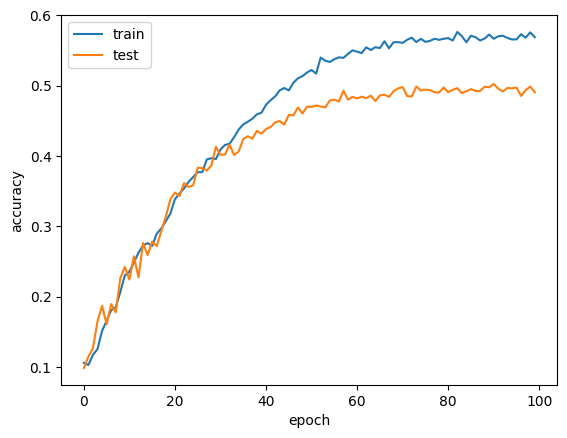

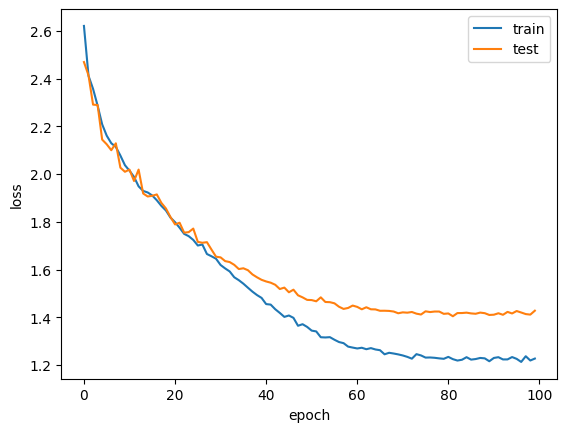

In [11]:
plt.plot(train_accuracy_h, label='train')
plt.plot(test_accuracy_h, label='test')
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.plot(train_loss_h, label='train')
plt.plot(test_loss_h, label='test')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [12]:
import pandas as pd
dict = {'train_acc': train_accuracy_h, 'test_acc': test_accuracy_h, 'train_loss': train_loss_h, 'test_loss' : test_loss_h}
df = pd.DataFrame(dict)
df.to_csv('logs/best_resnet_CIFAR10-DVS_ReLU1_ReLUmaxpool_128x128_FC2_128x128_pretrained_aug_corrected.csv')

In [13]:
df.head()

,train_acc,test_acc,train_loss,test_loss
0,0.105857,0.098667,2.620893,2.469472
1,0.102857,0.114667,2.411961,2.414066
2,0.117143,0.126667,2.357159,2.291090
3,0.125429,0.164667,2.286897,2.289618
4,0.151286,0.187000,2.208554,2.144630
